In [2]:
import numpy as np
from qiskit import QuantumCircuit
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
from qiskit.circuit import ParameterVector
from scipy.optimize import minimize

from numpy import random
%load_ext autoreload
%autoreload 2

from Part1 import encode
# Load MNIST dataset
DATA_PATH = '../data'
images = np.load(DATA_PATH+'/images.npy')
labels = np.load(DATA_PATH+'/labels.npy')

In [24]:
# We now define a two qubit unitary as defined in [3]
# def conv_circuit(params):
#     target = QuantumCircuit(2)
#     target.rz(-np.pi / 2, 1)
#     target.cx(1, 0)
#     target.rz(params[0], 0)
#     target.ry(params[1], 1)
#     target.cx(0, 1)
#     target.ry(params[2], 1)
#     target.cx(1, 0)
#     target.rz(np.pi / 2, 0)
#     return target

def conv_circuit(params, num_qubits):
    target = QuantumCircuit(num_qubits)
    for i,p in enumerate(params):
        target.rx(p,i)

    for q in range(num_qubits):
        target.cnot(q,(q+1)%num_qubits)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits)

    qc = conv_circuit(params=params, num_qubits=num_qubits)
    # for q1, q2 in zip(qubits[0::2], qubits[1::2]):
    #     qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
    #     qc.barrier()
    #     param_index += 3
    # for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
    #     qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
    #     qc.barrier()
    #     param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

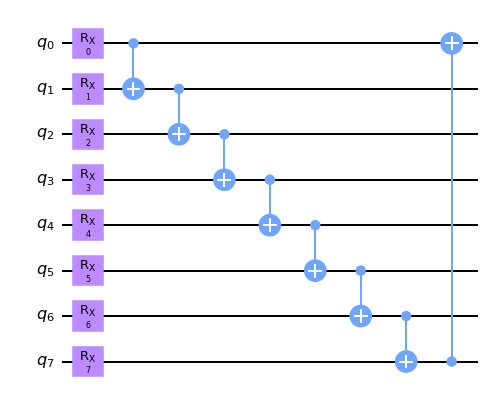

In [21]:
conv_circuit(params=np.arange(8),num_qubits=8).draw('mpl')

In [25]:
# first we need to encode it, lets assume this is done
def build_ansatz():
    ansatz = QuantumCircuit(8, name="Ansatz")

    # First Convolutional Layer
    ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

    # First Pooling Layer
    #ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

    # Second Convolutional Layer
    #ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

    # Second Pooling Layer
    #ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

    # Third Convolutional Layer
    #ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

    # Third Pooling Layer
    #ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

    return ansatz

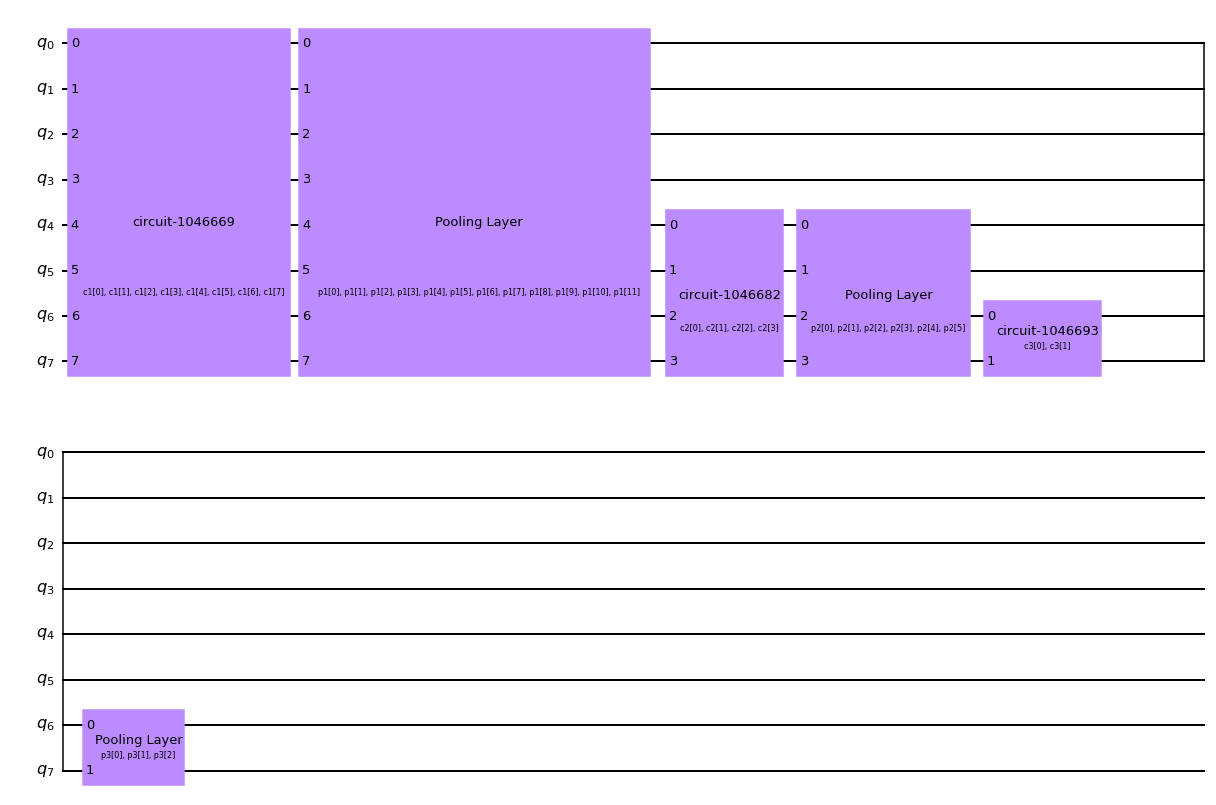

In [27]:
ansatz.draw('mpl')

In [28]:
# Combining the feature map and ansatz
def build_variational_circuit(image):
    circuit = QuantumCircuit(8)
    encoded_circuit = encode(image)
    circuit.compose(encoded_circuit,range(8), inplace=True)
    circuit.compose(ansatz, range(8), inplace=True)
    return circuit


(16, 16)


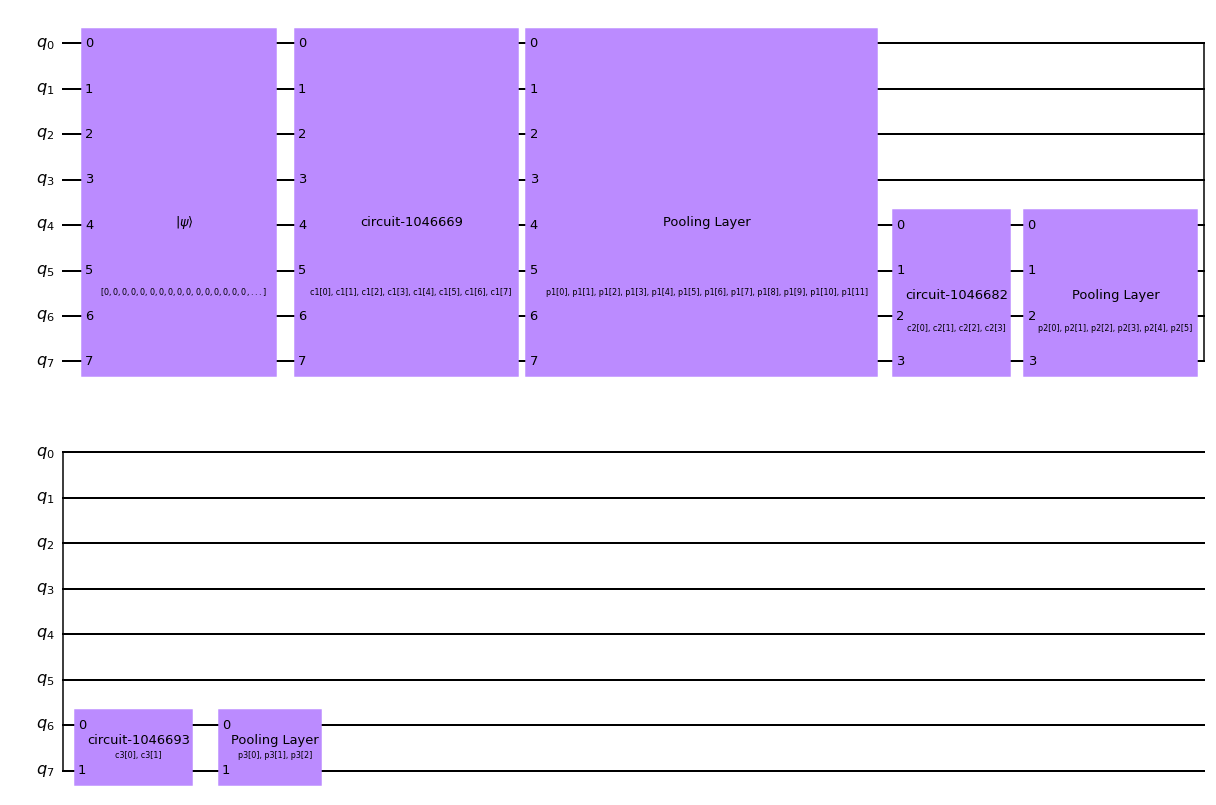

In [29]:
build_variational_circuit(images[0]).draw("mpl")

In [30]:
# each convolutional layer: num_qubits * 3 parameters = 24 parameters
# update: each convolutional layer: num_qubits = 8
# each pooling layer has: num_qubits // 2 * 3 = 12 parameters

"""
8 + 12
4 + 6
2+ 3
"""

'\n8 + 12\n4 + 6\n2+ 3\n'

In [31]:
8 + 12 + 4 + 6 + 2 +3 

35

In [10]:
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    return histogram
    

def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

In [11]:
# TODO:
# create proper loss function: using the labels
# create optimization loop: start with a random guess
# COBYLA
# https://quantumcomputing.stackexchange.com/questions/20718/software-tools-to-train-quantum-circuits-with-parameters

In [42]:
samples = images[:20]
labels = labels[:20]

def loss(x):
    # x must be of length: 63
    # y: actual label
    L = 0
    m = len(samples)
    for s,y in zip(samples, labels):
        circ = build_variational_circuit(s)
        histogram = simulate(circ.bind_parameters(x))
        y_hat = histogram_to_category(histogram=histogram)
        L += y*np.log(y_hat) + (1-y)*np.log(1-y_hat)

    return -L/m

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

initial_guess = random.rand(35)

In [ ]:
result = minimize(loss, initial_guess, method='cobyla', args=(images[:20], labels[:20]), options={'maxiter':20})

In [40]:
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=20, tol=0.0001)

In [43]:
# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
params = np.random.rand(35)
result = optimizer.minimize(
    fun=loss,
    x0=params)

(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(

In [37]:
initial_guess

array([1.75885721, 2.14085877, 1.80633453, 0.08396312, 0.18725486,
       1.98841135, 2.95341224, 1.43206113, 1.48515398, 0.43746308,
       0.89895042, 2.83240073, 1.69608017, 1.74259144, 2.81275562,
       1.71641526, 1.5049475 , 3.12361649, 0.71870861, 2.30860541,
       0.71961428, 2.20186079, 0.5859109 , 0.17410132, 1.58637974,
       0.59494899, 0.43628605, 1.48693571, 1.00892747, 0.55992049,
       1.67828095, 0.33399802, 1.40549356, 2.54266127, 0.08014689])

     fun: 0.7085705497089488
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20
  status: 2
 success: False
       x: array([2.75885721, 2.14085877, 1.80633453, 0.08396312, 0.18725486,
       1.98841135, 2.95341224, 1.43206113, 1.48515398, 0.43746308,
       0.89895042, 2.83240073, 1.69608017, 1.74259144, 2.81275562,
       1.71641526, 1.5049475 , 4.12361649, 0.71870861, 2.30860541,
       0.71961428, 2.20186079, 0.5859109 , 0.17410132, 1.58637974,
       0.59494899, 0.43628605, 1.48693571, 1.00892747, 0.55992049,
       1.67828095, 0.33399802, 1.40549356, 2.54266127, 0.08014689])
Final circuit
(16, 16)


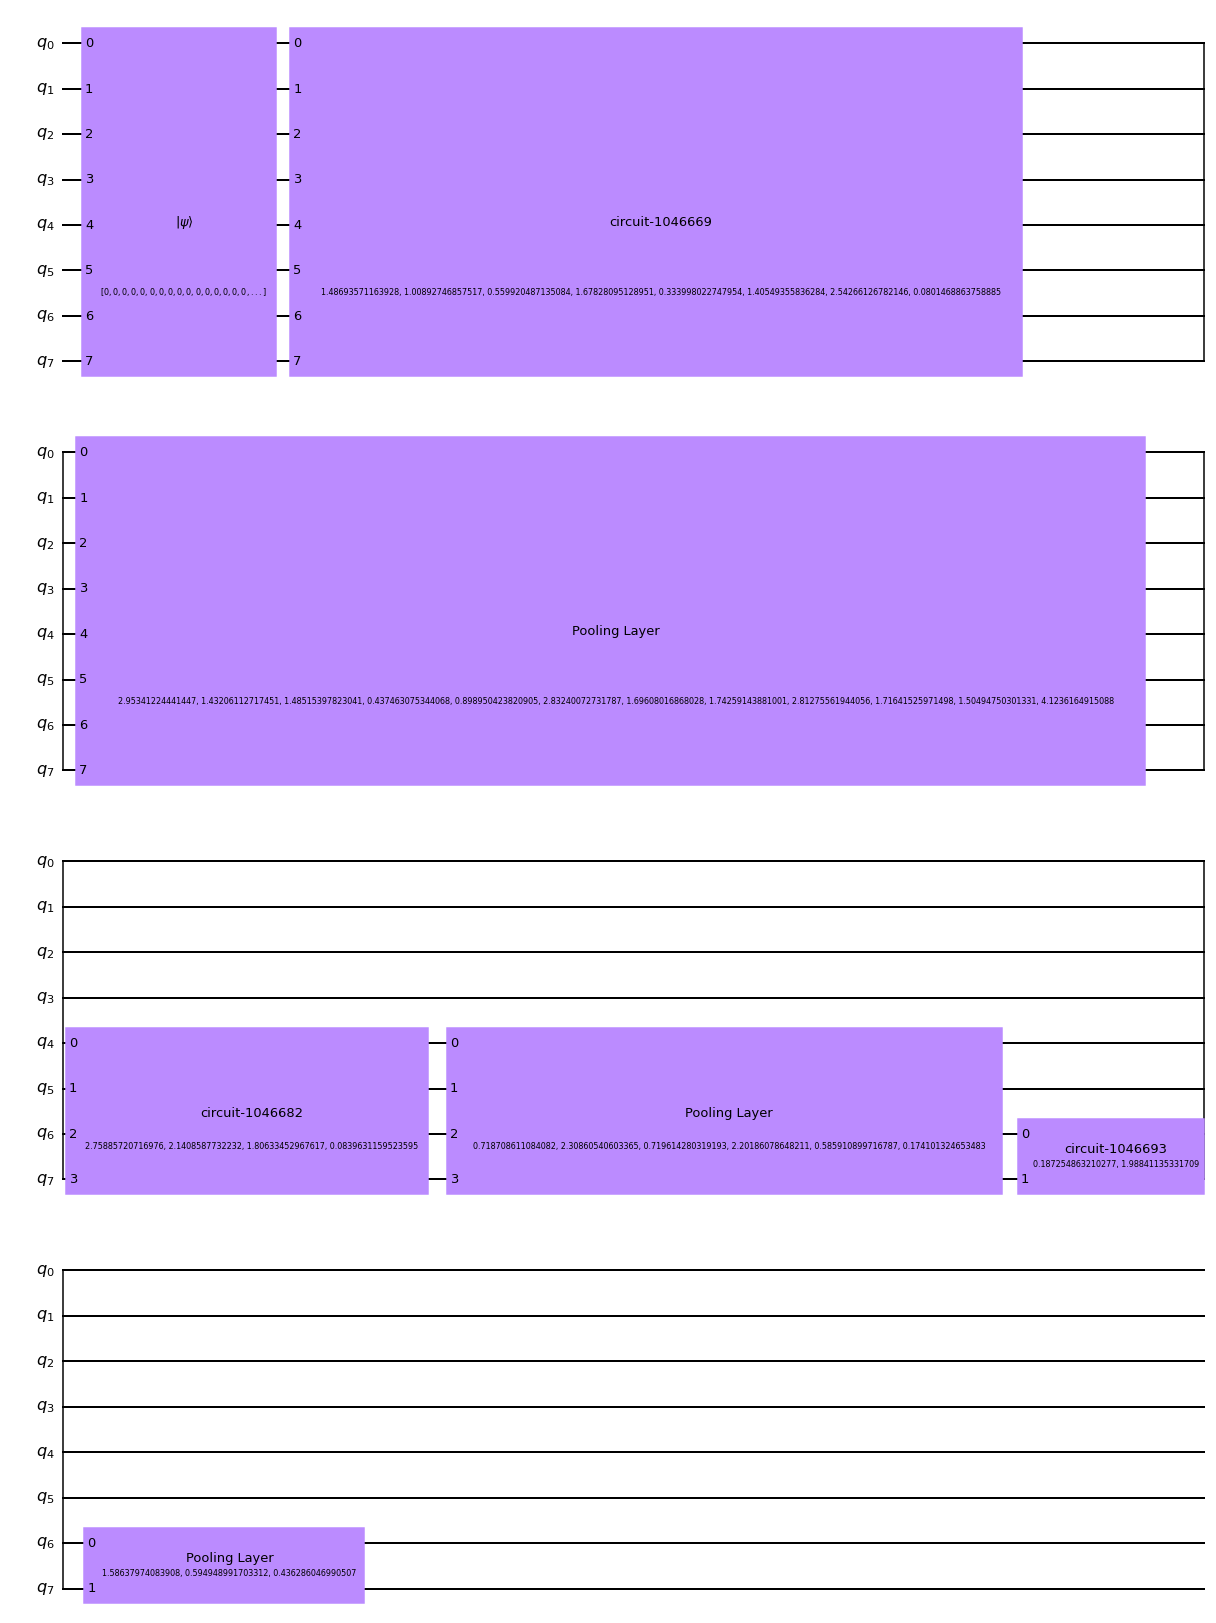

In [35]:
print(result)
print('Final circuit')
circ = build_variational_circuit(images[0])
circ.bind_parameters(result.x).draw('mpl')



In [ ]:
# it takes already quite a lot. I think it would be better if i decrease the number of parameters

In [38]:
circ = build_variational_circuit(images[0])
histogram = simulate(circ.bind_parameters(result.x))
y_hat = histogram_to_category(histogram=histogram)
y_hat

(16, 16)


0.4997457351585638

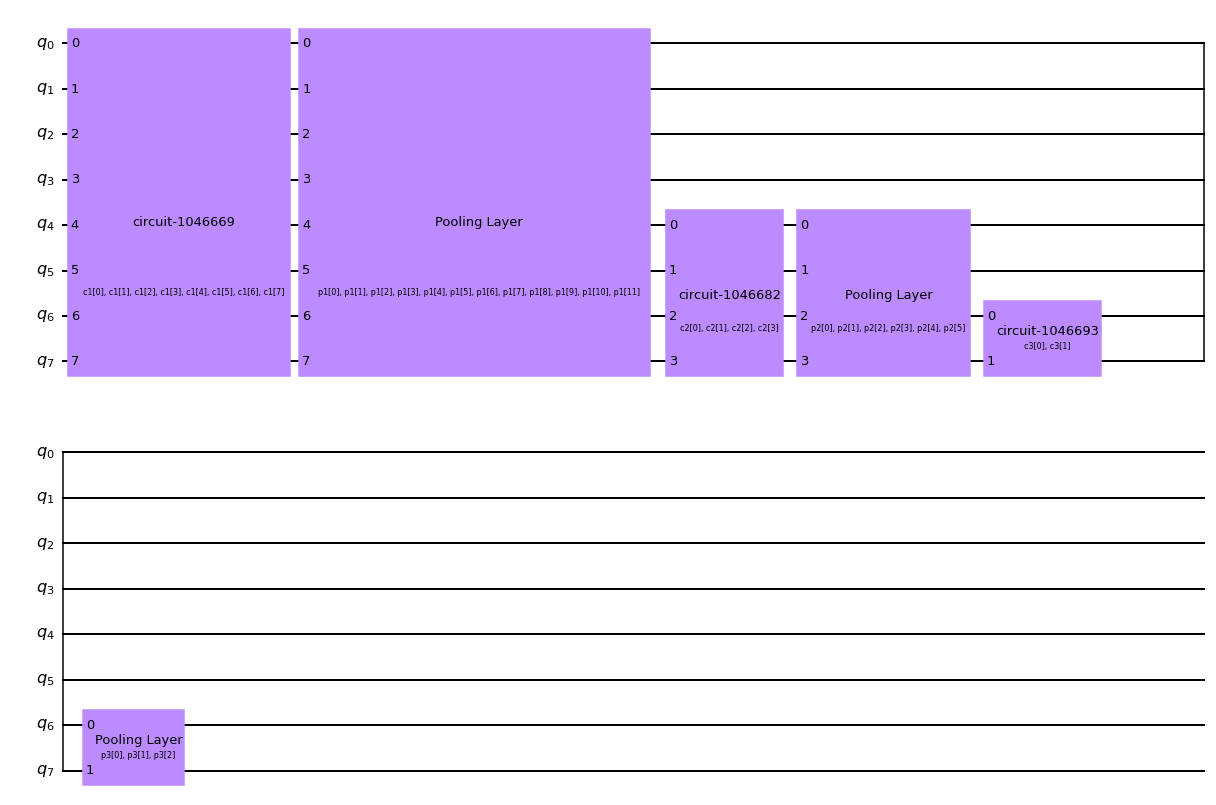

In [39]:
ansatz.draw('mpl')